In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose

from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

from prophet import Prophet

In [4]:
df = pd.read_csv('vacation.csv', index_col = 'Month', parse_dates = True)
df.index.freq = 'MS'
df

,Num_Search_Vacation
Month,
2004-01-01,94
2004-02-01,89
2004-03-01,86
2004-04-01,79
2004-05-01,89
...,...
2019-06-01,58
2019-07-01,56
2019-08-01,45


<AxesSubplot:xlabel='Month'>

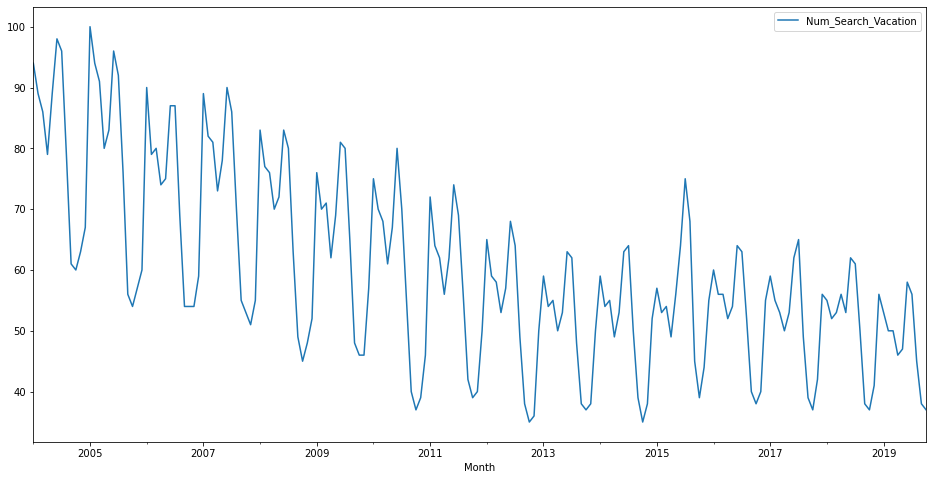

In [5]:
plt.rc("figure", figsize = (16, 8))
df.plot()

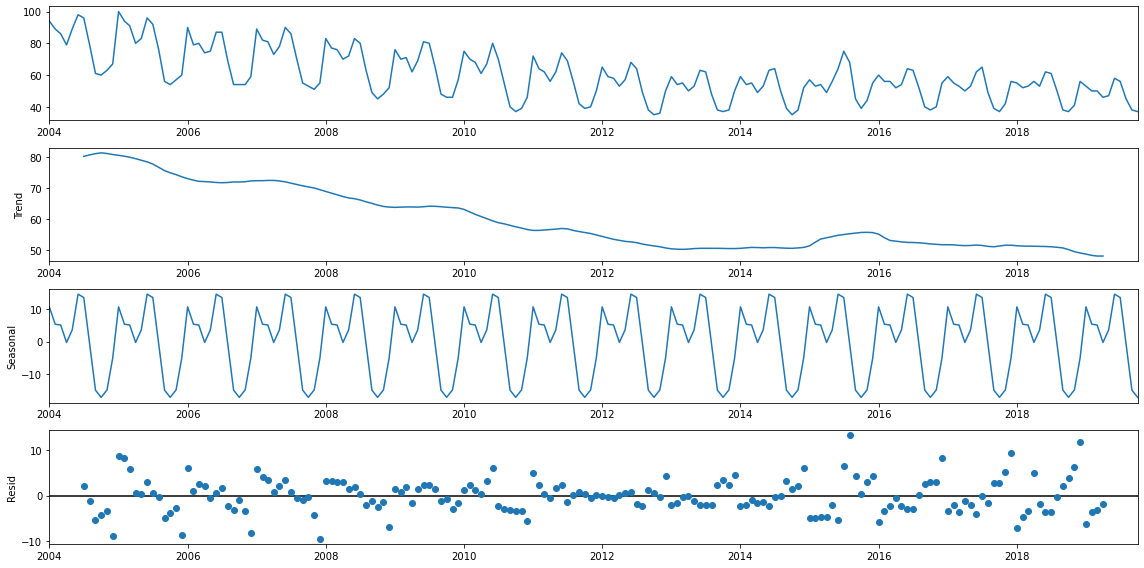

In [6]:
resultSeasonal = seasonal_decompose(df)
resultSeasonal.plot();

##### Looks like yearly seasonality

In [7]:
train_data = df.iloc[:-12]
test_data = df.iloc[-12:]

### Prophet

In [8]:
data = train_data.reset_index()[['Month', 'Num_Search_Vacation']]
data.columns = ['ds', 'y']
data

,ds,y
0,2004-01-01,94
1,2004-02-01,89
2,2004-03-01,86
3,2004-04-01,79
4,2004-05-01,89
...,...,...
173,2018-06-01,62
174,2018-07-01,61
175,2018-08-01,50
176,2018-09-01,38


In [9]:
#make forecast
fitProphet = Prophet(yearly_seasonality = True)
fitProphet.fit(data)
future = fitProphet.make_future_dataframe(len(test_data), freq = 'MS')
fcastProphet = fitProphet.predict(future)

#back to normal dataframe
prophetForecast = fcastProphet[['ds', 'yhat']].iloc[-len(test_data):]
prophetForecast.set_index('ds', inplace = True)
prophetForecast.index.name = 'Month'
prophetForecast.index.freq = 'MS'
prophetForecast.columns = ['Prophet']
print(mean_absolute_percentage_error(test_data, prophetForecast))
print(prophetForecast)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


0.13636612745588647
              Prophet
Month                
2018-11-01  36.290992
2018-12-01  45.570424
2019-01-01  62.841955
2019-02-01  57.429324
2019-03-01  56.921587
2019-04-01  51.328684
2019-05-01  55.181418
2019-06-01  65.820247
2019-07-01  65.343689
2019-08-01  52.383134
2019-09-01  36.773289
2019-10-01  34.238573


### SARIMA

In [10]:
auto_arima(df, seasonal = True, m = 12, trace = True).summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=986.851, Time=0.68 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1402.455, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1254.545, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1400.635, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=inf, Time=0.57 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=1006.523, Time=1.40 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=inf, Time=1.50 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=inf, Time=1.17 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=979.686, Time=1.39 sec
 ARIMA(1,1,2)(2,0,0)[12] intercept   : AIC=inf, Time=1.04 sec
 ARIMA(2,1,1)(2,0,0)[12] intercept   : AIC=inf, Time=1.31 sec
 ARIMA(3,1,2)(2,0,0)[12] intercept   : AIC=981.219, Time=1.47

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  190
Model:             SARIMAX(1, 1, 3)x(2, 0, [], 12)   Log Likelihood                -481.159
Date:                             Mon, 16 May 2022   AIC                            976.317
Time:                                     17:48:24   BIC                            999.009
Sample:                                          0   HQIC                           985.510
                                             - 190                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8505      0.109      7.783      0.000       0.636       1.065
ma.L1         -1.1763      0.141     -8.357      0.000      -1.452      -0.900
ma.L2          0.0425      0.114      0.371      0.710      -0.182       0.267
ma.L3          0.1436      0.111      1.292      0.196      -0.074       0.362
ar.S.L12       0.5819      0.056     10.417      0.000       0.472       0.691
ar.S.L24       0.3882      0.057      6.752      0.000       0.275       0.501
sigma2         8.0869      0.577     14.008      0.000       6.955       9.218
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                65.19
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.58   Skew:                             0.32
Prob(H) (two-sided):                  0.07   Kurtosis:                         5.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [11]:
fitSARIMA = SARIMAX(train_data, order = (1, 1, 3), seasonal_order = (2, 0, 0, 12)).fit()
fitSARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                 Num_Search_Vacation   No. Observations:                  178
Model:             SARIMAX(1, 1, 3)x(2, 0, [], 12)   Log Likelihood                -453.925
Date:                             Mon, 16 May 2022   AIC                            921.849
Time:                                     17:48:25   BIC                            944.082
Sample:                                 01-01-2004   HQIC                           930.866
                                      - 10-01-2018                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8520      0.107      7.949      0.000       0.642       1.062
ma.L1         -1.1825      0.137     -8.654      0.000      -1.450      -0.915
ma.L2          0.0527      0.117      0.451      0.652      -0.176       0.281
ma.L3          0.1401      0.113      1.244      0.213      -0.081       0.361
ar.S.L12       0.5861      0.060      9.797      0.000       0.469       0.703
ar.S.L24       0.3840      0.062      6.225      0.000       0.263       0.505
sigma2         8.3017      0.614     13.527      0.000       7.099       9.505
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                60.97
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.58   Skew:                             0.34
Prob(H) (two-sided):                  0.08   Kurtosis:                         5.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [12]:
start = len(train_data)
end = start + len(test_data) - 1
fcastSARIMA = fitSARIMA.predict(start = start, end = end, dynamic = False).rename('SARIMA')
print(mean_absolute_percentage_error(test_data, fcastSARIMA))

0.05245456992738964


### Holt-Winter's

In [13]:
#multiplicative for both
fitHoltWinter1 = ExponentialSmoothing(train_data, trend = 'mul', seasonal = 'mul', seasonal_periods = 12).fit()
fcastHoltWinter1 = fitHoltWinter1.forecast(len(test_data)).rename("Holt-Winter's predict 1")

#mul trend, add seasonal
fitHoltWinter2 = ExponentialSmoothing(train_data, trend = 'mul', seasonal = 'add', seasonal_periods = 12).fit()
fcastHoltWinter2 = fitHoltWinter2.forecast(len(test_data)).rename("Holt-Winter's predict 2")

#add trend, mul seasonal
fitHoltWinter3 = ExponentialSmoothing(train_data, trend = 'add', seasonal = 'mul', seasonal_periods = 12).fit()
fcastHoltWinter3 = fitHoltWinter3.forecast(len(test_data)).rename("Holt-Winter's predict 3")

#both additive
fitHoltWinter4 = ExponentialSmoothing(train_data, trend = 'add', seasonal = 'add', seasonal_periods = 12).fit()
fcastHoltWinter4 = fitHoltWinter4.forecast(len(test_data)).rename("Holt-Winter's predict 4")

print(mean_absolute_percentage_error(test_data, fcastHoltWinter1))
print(mean_absolute_percentage_error(test_data, fcastHoltWinter2))
print(mean_absolute_percentage_error(test_data, fcastHoltWinter3))
print(mean_absolute_percentage_error(test_data, fcastHoltWinter4))

c:\Users\Rudy\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
c:\Users\Rudy\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


0.06274859294265638
0.03843099837015275
0.061522271393622714
0.04118021443407744


##### Multiplicative trend and additive seasonal has best result but both additive is close as well.

### Plotting test data

<AxesSubplot:xlabel='Month'>

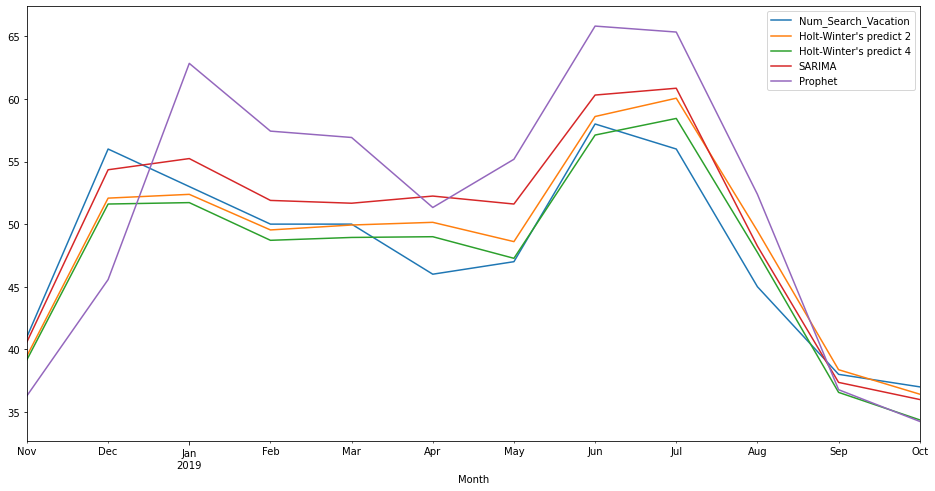

In [14]:
test_data.plot(legend = True)
fcastHoltWinter2.plot(legend = True)
fcastHoltWinter4.plot(legend = True)
fcastSARIMA.plot(legend = True)
prophetForecast['Prophet'].plot(legend = True)

##### The Holt-Winter's models are doing the best with following test data but SARIMA isn't too far off. Prophet is the best at replicating the shape of the test data but it's actual values are too high, leading to the worst performance.

### Final forecast

In [15]:
#Prophet
data = df.reset_index()[['Month', 'Num_Search_Vacation']]
data.columns = ['ds', 'y']

fitProphet = Prophet(yearly_seasonality = True)
fitProphet.fit(data)
future = fitProphet.make_future_dataframe(12, freq = 'MS')
fcastProphet = fitProphet.predict(future)

prophetForecast = fcastProphet[['ds', 'yhat']].iloc[-12:]
prophetForecast.set_index('ds', inplace = True)
prophetForecast.index.name = 'Month'
prophetForecast.index.freq = 'MS'
prophetForecast.columns = ['Prophet']

#SARIMA
fitSARIMA = SARIMAX(df, order = (1, 1, 3), seasonal_order = (2, 0, 0, 12)).fit()
fitSARIMA.summary()
start = len(df)
end = start + 11
fcastSARIMA = fitSARIMA.predict(start = start, end = end, dynamic = False).rename('SARIMA')

#Holt-Winter's
#mul trend, add seasonal
fitHoltWinter2 = ExponentialSmoothing(df, trend = 'mul', seasonal = 'add', seasonal_periods = 12).fit()
fcastHoltWinter2 = fitHoltWinter2.forecast(12).rename("Holt-Winter's predict 2")

#both additive
fitHoltWinter4 = ExponentialSmoothing(df, trend = 'add', seasonal = 'add', seasonal_periods = 12).fit()
fcastHoltWinter4 = fitHoltWinter4.forecast(12).rename("Holt-Winter's predict 4")

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
c:\Users\Rudy\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
c:\Users\Rudy\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


<AxesSubplot:xlabel='Month'>

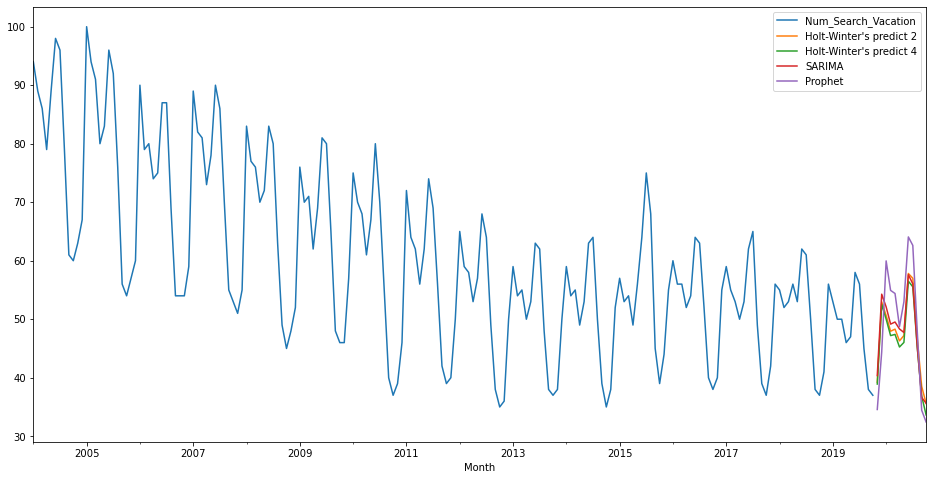

In [16]:
df.plot(legend = True)
fcastHoltWinter2.plot(legend = True)
fcastHoltWinter4.plot(legend = True)
fcastSARIMA.plot(legend = True)
prophetForecast['Prophet'].plot(legend = True)

<AxesSubplot:xlabel='Month'>

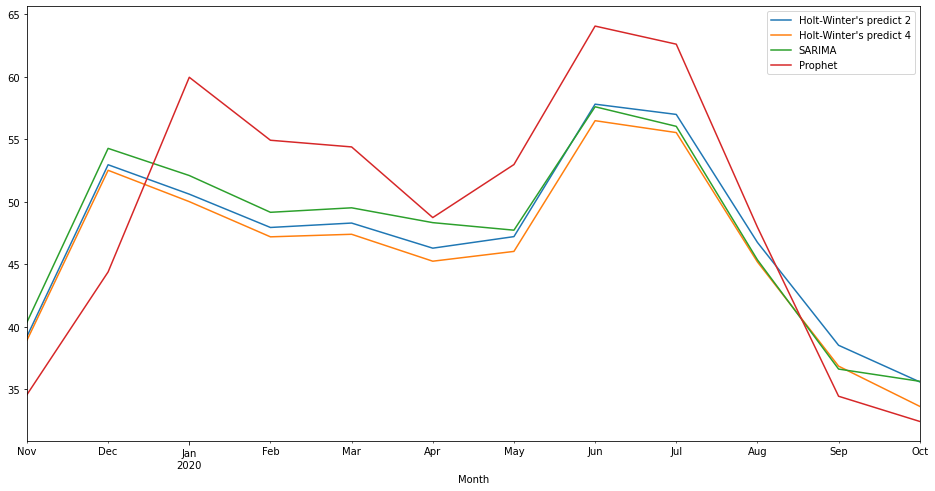

In [17]:
fcastHoltWinter2.plot(legend = True)
fcastHoltWinter4.plot(legend = True)
fcastSARIMA.plot(legend = True)
prophetForecast['Prophet'].plot(legend = True)

##### Same story as with test data. I'm not sure why prophet is expecting the time series to go up compared to the previous year when we're on a clear downwards trend. Even when i tried differencing the dataset prophet was reliably off from the test data and other models.

# Ex. 2: Neural Prophet

In [18]:
from neuralprophet import NeuralProphet

### Forecast of test data for normal prophet

In [32]:
data = train_data.reset_index()[['Month', 'Num_Search_Vacation']]
data.columns = ['ds', 'y']

#make forecast
fitProphet = Prophet(yearly_seasonality = True)
fitProphet.fit(data)
future = fitProphet.make_future_dataframe(len(test_data), freq = 'MS')
fcastProphet = fitProphet.predict(future)

#back to normal dataframe
prophetForecast = fcastProphet[['ds', 'yhat']].iloc[-len(test_data):]
prophetForecast.set_index('ds', inplace = True)
prophetForecast.index.name = 'Month'
prophetForecast.index.freq = 'MS'
prophetForecast.columns = ['Prophet']
print(mean_absolute_percentage_error(test_data, prophetForecast))

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


0.13636612745588647


### Neural Prophet

In [28]:
#make forecast
m = NeuralProphet(yearly_seasonality = True)
fitNP = m.fit(data, freq = 'MS')
futureNP = m.make_future_dataframe(data, periods = len(test_data))
fcastNP = m.predict(futureNP)

#back to normal dataframe
NPForecast = fcastNP[['ds', 'yhat1']].iloc[-len(test_data):]
NPForecast.set_index('ds', inplace = True)
NPForecast.index.name = 'Month'
NPForecast.index.freq = 'MS'
NPForecast.columns = ['NP']
print(mean_absolute_percentage_error(test_data, NPForecast))

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 91.011% of the data.
INFO:NP.df_utils:Major frequency MS corresponds to 91.011% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO:NP.df_utils:Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO:NP.utils:Disabling daily seasonality. Run NeuralProphet with daily_seasonality=

0.10907063497864344


<AxesSubplot:xlabel='Month'>

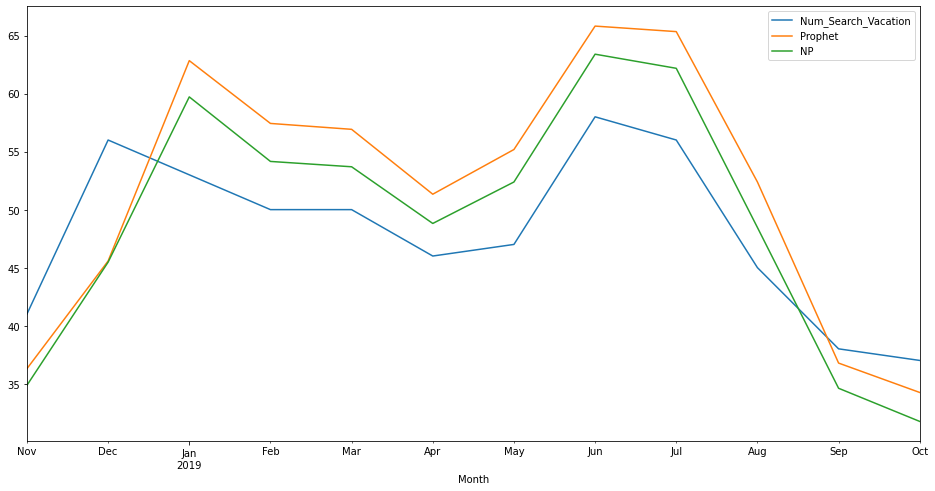

In [33]:
ax = test_data.plot(legend = True)
prophetForecast.plot(ax = ax, legend = True)
NPForecast.plot(ax = ax, legend = True)

##### Neural prophet is doing slightly better but still not great, same issues as i had previously with prophet's prediction. Either it expects the time series to go up or slow down in decreasing, not sure which one is true.

### Final forecast

In [34]:
#Prophet
data = df.reset_index()[['Month', 'Num_Search_Vacation']]
data.columns = ['ds', 'y']

fitProphet = Prophet(yearly_seasonality = True)
fitProphet.fit(data)
future = fitProphet.make_future_dataframe(12, freq = 'MS')
fcastProphet = fitProphet.predict(future)

prophetForecast = fcastProphet[['ds', 'yhat']].iloc[-12:]
prophetForecast.set_index('ds', inplace = True)
prophetForecast.index.name = 'Month'
prophetForecast.index.freq = 'MS'
prophetForecast.columns = ['Prophet']

#Neural Prophet
m = NeuralProphet(yearly_seasonality = True)
fitNP = m.fit(data, freq = 'MS')
futureNP = m.make_future_dataframe(data, periods = 12)
fcastNP = m.predict(futureNP)

NPForecast = fcastNP[['ds', 'yhat1']].iloc[-12:]
NPForecast.set_index('ds', inplace = True)
NPForecast.index.name = 'Month'
NPForecast.index.freq = 'MS'
NPForecast.columns = ['NP']

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 91.053% of the data.
INFO:NP.df_utils:Major frequency MS corresponds to 91.053% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO:NP.df_utils:Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.s

<AxesSubplot:xlabel='Month'>

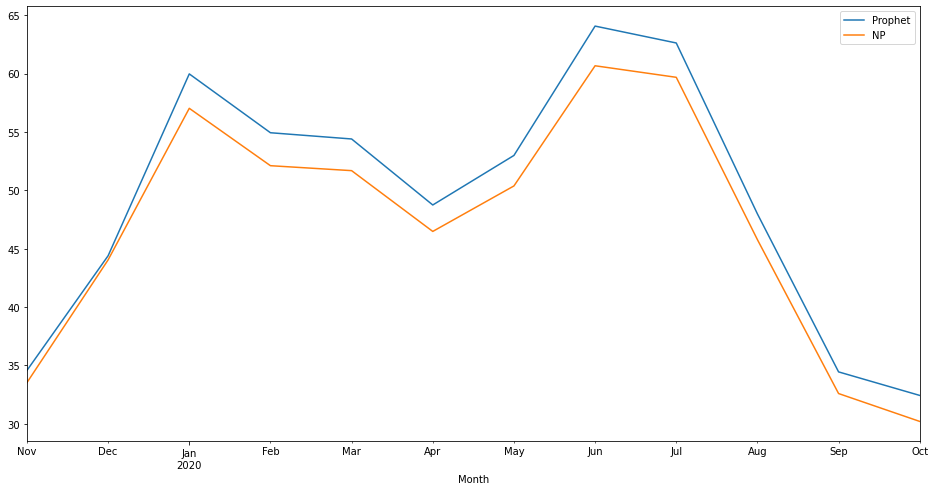

In [36]:
ax = prophetForecast.plot(legend = True)
NPForecast.plot(ax = ax, legend = True)

##### The result is once again slightly better but still not good enough compared to SARIMA and Holt-Winter's.

### Checking if differencing helps

In [49]:
train_data = df.diff().dropna().iloc[:-12]
test_data = df.diff().dropna().iloc[-12:]

In [50]:
auto_arima(df.diff().dropna(), seasonal = True, m = 12, trace = True).summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=983.887, Time=0.80 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1402.455, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1254.548, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1400.635, Time=0.00 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(2,0,2)(2,0,1)[12] intercept   : AIC=1006.498, Time=1.23 sec
 ARIMA(2,0,2)(1,0,2)[12] intercept   : AIC=inf, Time=1.37 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(2,0,2)(0,0,2)[12] intercept   : AIC=inf, Time=1.20 sec
 ARIMA(2,0,2)(2,0,0)[12] intercept   : AIC=979.808, Time=1.31 sec
 ARIMA(1,0,2)(2,0,0)[12] intercept   : AIC=inf, Time=1.06 sec
 ARIMA(2,0,1)(2,0,0)[12] intercept   : AIC=1002.469, Time=1.14 sec
 ARIMA(3,0,2)(2,0,0)[12] intercept   : AIC=981.406, Time

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  189
Model:             SARIMAX(1, 0, 1)x(2, 0, [], 12)   Log Likelihood                -482.344
Date:                             Mon, 16 May 2022   AIC                            974.688
Time:                                     18:13:55   BIC                            990.896
Sample:                                          0   HQIC                           981.254
                                             - 189                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6608      0.054     12.300      0.000       0.555       0.766
ma.L1         -0.9651      0.023    -41.135      0.000      -1.011      -0.919
ar.S.L12       0.5839      0.056     10.485      0.000       0.475       0.693
ar.S.L24       0.3813      0.057      6.672      0.000       0.269       0.493
sigma2         8.2277      0.594     13.853      0.000       7.064       9.392
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                56.52
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               1.57   Skew:                             0.26
Prob(H) (two-sided):                  0.08   Kurtosis:                         5.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [51]:
#Prophet
data = train_data.reset_index()[['Month', 'Num_Search_Vacation']]
data.columns = ['ds', 'y']

fitProphet = Prophet(yearly_seasonality = True)
fitProphet.fit(data)
future = fitProphet.make_future_dataframe(12, freq = 'MS')
fcastProphet = fitProphet.predict(future)

prophetForecast = fcastProphet[['ds', 'yhat']].iloc[-12:]
prophetForecast.set_index('ds', inplace = True)
prophetForecast.index.name = 'Month'
prophetForecast.index.freq = 'MS'
prophetForecast.columns = ['Prophet']

#Neural Prophet
m = NeuralProphet(yearly_seasonality = True)
fitNP = m.fit(data, freq = 'MS')
futureNP = m.make_future_dataframe(data, periods = 12)
fcastNP = m.predict(futureNP)

NPForecast = fcastNP[['ds', 'yhat1']].iloc[-len(test_data):]
NPForecast.set_index('ds', inplace = True)
NPForecast.index.name = 'Month'
NPForecast.index.freq = 'MS'
NPForecast.columns = ['NP']

#SARIMA
fitSARIMA = SARIMAX(train_data, order = (1, 0, 1), seasonal_order = (2, 0, 0, 12)).fit()
start = len(train_data)
end = start + len(test_data) - 1
fcastSARIMA = fitSARIMA.predict(start = start, end = end, dynamic = False).rename('SARIMA')

#Holt-Winter's, only both additive work
fitHoltWinter = ExponentialSmoothing(train_data, trend = 'add', seasonal = 'add', seasonal_periods = 12).fit()
fcastHoltWinter = fitHoltWinter.forecast(len(test_data)).rename("Holt-Winter's predict 4")


print("Prophet: ", mean_absolute_percentage_error(test_data, prophetForecast))
print("Neural Prophet: ", mean_absolute_percentage_error(test_data, NPForecast))
print("Sarima: ", mean_absolute_percentage_error(test_data, fcastSARIMA))
print("Holt-Winter's: ", mean_absolute_percentage_error(test_data, fcastHoltWinter))

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 90.96% of the data.
INFO:NP.df_utils:Major frequency MS corresponds to 90.96% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO:NP.df_utils:Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set

Prophet:  77643564309765.58
Neural Prophet:  156595939267926.5
Sarima:  64535387573843.31
Holt-Winter's:  64867901512658.34


c:\Users\Rudy\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
c:\Users\Rudy\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


##### There is something wrong with calculating MAPE for differenced time series

<AxesSubplot:xlabel='Month'>

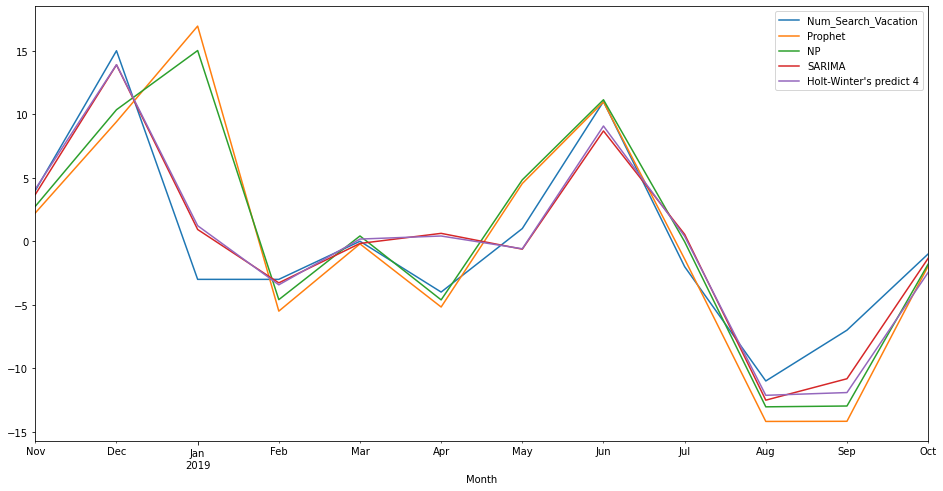

In [53]:
ax = test_data.plot(legend = True)
prophetForecast.plot(ax = ax, legend = True)
NPForecast.plot(ax = ax, legend = True)
fcastSARIMA.plot(ax = ax, legend = True)
fcastHoltWinter.plot(ax = ax, legend = True)

### We can see differencing didn't help, both Prophet and Neural Prophet follow the same mistaken trajectory.